# Metode strojnog učenja u obradi teksta
---

In [1]:
# preambula
# paketi
import sklearn
import nltk
import pandas as pd
import re


# scikit-learn funkcije
from sklearn.feature_extraction.text import CountVectorizer # pretvara dokumente u vektore frekvencija tokena
from sklearn.feature_extraction.text import TfidfVectorizer # 

# NLTK funkcije
from nltk.stem.porter import PorterStemmer # korijenovatelj engleskih riječi
from sklearn.cluster import KMeans   # algoritam klasteriranja
from pprint import pprint



# Nadzirano učenje 

 
![ML model](supervised-classification.png)

## Primjer 1: identifikacija roda
> Muška i ženska imena imaju nekih bitnih razlika: imena koja završavaju na a,e,i su većim dijelom ženska imena, dok imena koja završavaju na k,o,r,s su vjerojatnije muška...

### Klasifikator: Naivni Bayesov klasifikator

Za dani ulaz $x$ sa svojstvima $F$ Naivni Bayes pridružuje labelu $l\in L$ koja maksimizira vjerojatnost $P(l|F)$. Na temelju trening skupa računa
$$ P(l | F) = P(F,l)/P(F) $$
gdje $P(F) = \sum_{l\in L} P(F,l)$. Za računanje $P(F,l)$ koristi prior distribuciju $P(l)$ (vjerojatnost oznake $l$) uz pretpostavku nezavisnosti svojstava:
    $$ P(F,l) = P(l) \times \prod_{f\in F} P(f | l)$$
 
Vjerojatnosti $P(f | l)$ i $P(l)$ računa na temelju frekvencija oznaka i svojstava u trening skupu. Npr. $P(f,l) = \textrm{count}(f,l)/\textrm{count}(l)$. U praksi, sofisticirane tehnike koriste se za zaglađivanje tih funkcija (izbjegavanje 0 vrijednosti).

Sljedeće funkcija određuje svojstvo zadnjeg slova u riječi.


In [2]:
def gender_features(word):
    return {'last_letter':word[-1]}

gender_features('shrek')

{'last_letter': 'k'}

Učitajmo sada skup podataka koji pored imena sadrži i oznake grupe.

In [3]:
from nltk.corpus import names
import random

names = ([(name, 'male') for name in names.words('male.txt')] + [(name, 'female') for name in names.words('female.txt')])
random.shuffle(names)
print(names[1:10])

[('Val', 'male'), ('Gabrielle', 'female'), ('Grover', 'male'), ('Caitlin', 'female'), ('Carlina', 'female'), ('Hanni', 'female'), ('Arlette', 'female'), ('Merl', 'female'), ('Tracey', 'male')]


Podijelimo `names` uz pomoć ekstraktora svojstva u 2 skupa svojstava: **skup za treniranje** i **skup za testiranje**. Iskoristimo dostupni klasifikator `NaiveBayesClassfier` (objasnit ćemo poslije...)

In [26]:
# skup svojstava
featuresets = [(gender_features(n), g) for (n,g) in names]
# podjela u treniranje i test
train_set, test_set = featuresets[500:], featuresets[:500]


In [27]:
# definiran model klasifikacije na temelju podataka
classifier = nltk.NaiveBayesClassifier.train(train_set)

Provjeriti klasifikator s novim pojmom. Kolika je preciznost klasifikatora?

In [28]:
# provjeri klasifikaciju na novim pojmovima
classifier.classify(gender_features('Neo'))
classifier.classify(gender_features('Trinity'))
classifier.classify(gender_features('Cathleen'))

# provjeri preciznost na test skupu
nltk.classify.accuracy(classifier,test_set)
# koja slova najviše diskriminiraju imena?
#classifier.show_most_informative_features(5)



0.734

> Problem odabira **dobrog skupa svojstava**: *overfitting* vs *underfitting*

Analiziranje loše klasifikacije možemo probati odabrati dobar skup svojstava uz pomoć **validacijskog skupa** podataka

In [29]:
# podaci
random.shuffle(names)
train_names = names[1500:]
devtest_names = names[500:1500] # na ovom skupu radimo analizu greške
test_names = names[:500]

In [30]:
# feature extractor
def gender_features(word):
    return {'last_letter':word[-1]}

# model
train_set = [(gender_features(n), g) for (n,g) in train_names]
devtest_set = [(gender_features(n), g) for (n,g) in devtest_names]
test_set = [(gender_features(n), g) for (n,g) in test_names]
# treniranje
classifier = nltk.NaiveBayesClassifier.train(train_set)
# analiza greške
print(nltk.classify.accuracy(classifier, devtest_set))
#print(nltk.classify.accuracy(classifier, test_set))

# ispitati greške
errors = []
for (name, tag) in devtest_names:
    guess = classifier.classify(gender_features(name))
    if guess != tag:
        errors.append( (tag, guess, name) )
        
for (tag, guess, name) in sorted(errors): 
    print('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name))
    


0.777
correct=female   guess=male     name=Abagail                       
correct=female   guess=male     name=Abigael                       
correct=female   guess=male     name=Alison                        
correct=female   guess=male     name=Alix                          
correct=female   guess=male     name=Allsun                        
correct=female   guess=male     name=Anet                          
correct=female   guess=male     name=Ardelis                       
correct=female   guess=male     name=Arleen                        
correct=female   guess=male     name=Ashlen                        
correct=female   guess=male     name=Averil                        
correct=female   guess=male     name=Avis                          
correct=female   guess=male     name=Ayn                           
correct=female   guess=male     name=Beitris                       
correct=female   guess=male     name=Birgit                        
correct=female   guess=male     name=Bo   

In [31]:
classifier.classify(gender_features('Alys'))

'male'

Što nam govori ovaj primjer? 
> Neki sufiksi koji imaju barem 2 člana bolje karakteriziraju ime, npr. `Cathle(en)-> female` 

In [32]:
def gender_features2(word):
    return {'suffix1':word[-1:], 'suffix2':word[-2:]}

# model
train_set = [(gender_features2(n), g) for (n,g) in train_names]
devtest_set = [(gender_features2(n), g) for (n,g) in devtest_names]
test_set = [(gender_features2(n), g) for (n,g) in test_names]
# treniranje
classifier = nltk.NaiveBayesClassifier.train(train_set)
# analiza greške
print(nltk.classify.accuracy(classifier, devtest_set))
#print(nltk.classify.accuracy(classifier, test_set))

# ispitati greške
errors = []
for (name, tag) in devtest_names:
    guess = classifier.classify(gender_features2(name))
    if guess != tag:
        errors.append( (tag, guess, name) )
        
for (tag, guess, name) in sorted(errors): 
    print('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name))





0.783
correct=female   guess=male     name=Abagail                       
correct=female   guess=male     name=Abigael                       
correct=female   guess=male     name=Ajay                          
correct=female   guess=male     name=Alison                        
correct=female   guess=male     name=Alix                          
correct=female   guess=male     name=Anet                          
correct=female   guess=male     name=Ardath                        
correct=female   guess=male     name=Ardelis                       
correct=female   guess=male     name=Arleen                        
correct=female   guess=male     name=Ashlen                        
correct=female   guess=male     name=Averil                        
correct=female   guess=male     name=Avis                          
correct=female   guess=male     name=Beitris                       
correct=female   guess=male     name=Birgit                        
correct=female   guess=male     name=Bo   

In [33]:
classifier.classify(gender_features('Alys'))

'female'

### Metoda: Logistička regresija

Logistička regresija je metoda nadziranog strojnog učenja koja se koristi za binarnu klasifikaciju. Ona modelira vjerojatnost da ulazni podatak pripada određenoj klasi koristeći logističku (sigmoidnu) funkciju. Model pretvara linearnu kombinaciju ulaznih značajki u vjerojatnost između 0 i 1, što omogućava donošenje odluke o klasifikaciji na temelju praga (obično 0.5).

Matematički, logistička regresija koristi formulu:
$$ P(y=1 | x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \dots + \beta_n x_n)}} $$

gdje su $\beta_i$ koeficijenti naučeni iz podataka, a $x_i$ ulazne značajke. Treniranje se obavlja minimizacijom funkcije gubitka, često koristeći maksimalnu vjerojatnost ili regularizirane varijante.

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

# Priprema podataka
featuresets = [(gender_features2(n), g) for (n, g) in names]
X_dict = [f for f, g in featuresets]
y = [g for f, g in featuresets]

# pretvori rječnik u vektor (matricu)
vec = DictVectorizer()
X = vec.fit_transform(X_dict)

# Podjela na trening i test skup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treniranje logističke regresije
lr_classifier = LogisticRegression(random_state=42)
lr_classifier.fit(X_train, y_train)

# Testiranje
accuracy = lr_classifier.score(X_test, y_test)
print(f"Točnost logističke regresije: {accuracy:.2f}")

# Primjer klasifikacije
test_name = 'Alys'
test_features = vec.transform([gender_features2(test_name)])
prediction = lr_classifier.predict(test_features)
print(f"Predikcija za '{test_name}': {prediction[0]}")

Točnost logističke regresije: 0.77
Predikcija za 'Alys': female


# Nenadzirano učenje

## Analiziranje  teksta

Pristup analize: *rečenica kao **neporedani skup riječi** ("bag-of-words" analiza)*. Riječi se vektoriziraju kao numeričke vrijednosti prema koracima:
 1. **Raščlamba (tokenizacija)**:  pretvara riječi/fraze u niz tokena i pridružuje numeričke identifikatore; `nltk.tokenize`
 2. **Prebrojavanje**: prebrojavanje pojave tokena u dokumentima `scikit-learn`
 3. **Normalizacija**: ponderiranje važnosti tokena u dokumentima `scikit-learn`



Reprezentacija teksta u računalu:
* frekvencija pojedinog tokena u dokumentu: **svojstvo (engl. feature)**: 
* vektor frekvencija tokena: **uzorak**
* koje **statistike** u postupku normalizacije reflektiraju  koliko je važna neka riječ u dokumentu nekog korpusa? TF-IDF


> **CILJ:**  Odrediti sličnost dokumenata

Primjer vlastitog korpusa dokumenata:



In [13]:
# primjer teksta
from data import texts1 as texts
pprint(texts)

['Penny bought bright blue fishes.',
 'Penny bought bright blue and orange fish.',
 'The cat ate a fish at the store.',
 'Penny went to the store. Penny ate a bug. Penny saw a fish.',
 'It meowed once at the bug, it is still meowing at the bug and the fish',
 'The cat is at the fish store. The cat is orange. The cat is meowing at the '
 'fish.',
 'Penny is a fish']


Vektorizirajmo dokumente s obzirom na pojavnost tokena uz pomoć `sklearn`-ova [`CountVector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [14]:
count_vectorizer = CountVectorizer()
# tokeniziraj i prebroj
X = count_vectorizer.fit_transform(texts)
# koristi panadas za prikaz
#pd.DataFrame(X.toarray())
# poboljsaj prikaz?
pd.DataFrame(X.toarray(),columns=count_vectorizer.get_feature_names_out())

,and,at,ate,blue,bought,bright,bug,cat,fish,fishes,...,meowing,once,orange,penny,saw,still,store,the,to,went
0,0,0,0,1,1,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,1,0,0,1,1,1,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
2,0,1,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,2,0,0
3,0,0,1,0,0,0,1,0,1,0,...,0,0,0,3,1,0,1,1,1,1
4,1,2,0,0,0,0,2,0,1,0,...,1,1,0,0,0,1,0,3,0,0
5,0,2,0,0,0,0,0,3,2,0,...,1,0,1,0,0,0,1,5,0,0
6,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


Iz prethodnog vidimo da retci odgovaraju našim dokumentima, a stupci riječima unutar rečenice. Uočimo da u tekstu ima podosta **učestalih riječi** (engl. stopwords) koje želimo filtrirati!

In [15]:
# novi vektorizer
count_vectorizer = CountVectorizer(stop_words='english')
X = count_vectorizer.fit_transform(texts)
pd.DataFrame(X.toarray(),columns=count_vectorizer.get_feature_names_out())

,ate,blue,bought,bright,bug,cat,fish,fishes,meowed,meowing,orange,penny,saw,store,went
0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0
1,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0
2,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0
3,1,0,0,0,1,0,1,0,0,0,0,3,1,1,1
4,0,0,0,0,2,0,1,0,1,1,0,0,0,0,0
5,0,0,0,0,0,3,2,0,0,1,1,0,0,1,0
6,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


Dodatna filtracija tokena: 
> normalizacija (lematizacija ili korijenovanje) tokena.

In [16]:
from nltk.stem import WordNetLemmatizer 

# lematizator 
lemmatizer = WordNetLemmatizer() 
# tokenizator
def tokenizer(text):
    words = re.sub(r'[^A-Za-z0-9\-]'," ",text).lower().split() # prave riječi u tekstu
    words = [lemmatizer.lemmatize(word) for word in words]
    return words
# vektorizator
count_vectorizer = CountVectorizer(stop_words='english',tokenizer=tokenizer)
X = count_vectorizer.fit_transform(texts)
pd.DataFrame(X.toarray(),columns=count_vectorizer.get_feature_names_out())

C:\Users\Domagoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Domagoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\Domagoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


,ate,blue,bought,bright,bug,cat,fish,meowed,meowing,orange,penny,saw,store,went
0,0,1,1,1,0,0,1,0,0,0,1,0,0,0
1,0,1,1,1,0,0,1,0,0,1,1,0,0,0
2,1,0,0,0,0,1,1,0,0,0,0,0,1,0
3,1,0,0,0,1,0,1,0,0,0,3,1,1,1
4,0,0,0,0,2,0,1,1,1,0,0,0,0,0
5,0,0,0,0,0,3,2,0,1,1,0,0,1,0
6,0,0,0,0,0,0,1,0,0,0,1,0,0,0


**TF-IDF**
**Term-Frequency-Inverse-Document-Frequency** je statistika koja se koristi za vrednovanje koliko neka riječ nosi informacije u korpusu s obzirom na njenu pojavnost:
$$\textrm{tf-idf}(t,d)=\mathrm{tf}(t,d)\times \mathrm{idf}(t)$$

**Term Frequency (Frekvencija pojma)**
Utvrđivanje relativne pojavnosti tokena $t$ u dokumentu $d$: $$\mathrm{tf}(t,d)=\frac{f(t,d)}{\sum_{v\in d} f(v,d)}$$ gfje je $f(v,d)$ broj pojave tokena $v$ u dokumentu $d$.




Koristimo `sklearn`-ov [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [17]:

tfidf_vectorizer = TfidfVectorizer(stop_words='english', tokenizer=tokenizer, use_idf=False, norm='l1')
X = tfidf_vectorizer.fit_transform(texts)
df=pd.DataFrame(X.toarray(), columns = tfidf_vectorizer.get_feature_names_out())
pprint(texts)
df

['Penny bought bright blue fishes.',
 'Penny bought bright blue and orange fish.',
 'The cat ate a fish at the store.',
 'Penny went to the store. Penny ate a bug. Penny saw a fish.',
 'It meowed once at the bug, it is still meowing at the bug and the fish',
 'The cat is at the fish store. The cat is orange. The cat is meowing at the '
 'fish.',
 'Penny is a fish']


C:\Users\Domagoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Domagoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


,ate,blue,bought,bright,bug,cat,fish,meowed,meowing,orange,penny,saw,store,went
0,0.000000,0.200000,0.200000,0.200000,0.000000,0.000,0.200000,0.0,0.000,0.000000,0.200000,0.000000,0.000000,0.000000
1,0.000000,0.166667,0.166667,0.166667,0.000000,0.000,0.166667,0.0,0.000,0.166667,0.166667,0.000000,0.000000,0.000000
2,0.250000,0.000000,0.000000,0.000000,0.000000,0.250,0.250000,0.0,0.000,0.000000,0.000000,0.000000,0.250000,0.000000
3,0.111111,0.000000,0.000000,0.000000,0.111111,0.000,0.111111,0.0,0.000,0.000000,0.333333,0.111111,0.111111,0.111111
4,0.000000,0.000000,0.000000,0.000000,0.400000,0.000,0.200000,0.2,0.200,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.375,0.250000,0.0,0.125,0.125000,0.000000,0.000000,0.125000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.500000,0.0,0.000,0.000000,0.500000,0.000000,0.000000,0.000000


**Inverse Document Frequency (Inverzna dokumenta frekvencija)**

Mjera koliko informacije nosi token $t$ s obzirom na pojavnost u svim dokumentima korpusa $D$:

$$ \mathrm {idf} (t)=-\log {\frac {\mathrm{df}(t,D)}{|D|}}$$
gdje je $\mathrm{df}(t,D)$ broj dokumenata u $D$ koje sadrži token $t$. 



Paket `sklearn` omogućava korištenje FT-IDF s opcijom `use_idf=True` u `TFidfVectorizer` metodi za vektorizaciju zajedno s odabirom normalizacije vektora korištenjem $L_1$ ili $L_2$ norme. 

> Napomena: `sklearn` implementira `TFidfVectorizer`  $\mathrm{idf()}$ tako da u brojnik i nazivnik doda 1 kako bi se izbjeglo dijeljenje s 0.



In [18]:
# iskoristimo idf
idf_vectorizer = TfidfVectorizer(stop_words='english', tokenizer=tokenizer, use_idf=True, norm='l2')
X = idf_vectorizer.fit_transform(texts)
df = pd.DataFrame(X.toarray(), columns=idf_vectorizer.get_feature_names_out())
df

C:\Users\Domagoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Domagoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


,ate,blue,bought,bright,bug,cat,fish,meowed,meowing,orange,penny,saw,store,went
0,0.000000,0.512612,0.512612,0.512612,0.000000,0.000000,0.258786,0.000000,0.000000,0.000000,0.380417,0.000000,0.000000,0.000000
1,0.000000,0.456170,0.456170,0.456170,0.000000,0.000000,0.230292,0.000000,0.000000,0.456170,0.338530,0.000000,0.000000,0.000000
2,0.578752,0.000000,0.000000,0.000000,0.000000,0.578752,0.292176,0.000000,0.000000,0.000000,0.000000,0.000000,0.494698,0.000000
3,0.303663,0.000000,0.000000,0.000000,0.303663,0.000000,0.153301,0.000000,0.000000,0.000000,0.676058,0.365821,0.259561,0.365821
4,0.000000,0.000000,0.000000,0.000000,0.772313,0.000000,0.194947,0.465201,0.386156,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.840166,0.282766,0.000000,0.280055,0.280055,0.000000,0.000000,0.239382,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.562463,0.000000,0.000000,0.000000,0.826823,0.000000,0.000000,0.000000




**Princip klasteriranja**: korištenjem **$k$-Means** algoritma ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)) cilj nam je odrediti $k$ klastera dokumenata našeg korpusa tako da ukupna udaljenost između dokumenata istog klastera bude najmanja moguća!  


In [19]:
# ponovimo podatke ...
vectorizer = TfidfVectorizer(use_idf=True, tokenizer=tokenizer, stop_words='english')
X = vectorizer.fit_transform(texts)

C:\Users\Domagoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Domagoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [20]:
# algoritam klasteriranja
from sklearn.cluster import KMeans
# broj klastera 2
number_of_clusters = 2
km = KMeans(n_clusters=number_of_clusters)
km.fit(X)

,n_clusters,2
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [21]:
# uljepsajmo prikaz podataka
results = pd.DataFrame()
results['text'] = texts
results['category'] = km.labels_ # klaster oznake
results

,text,category
0,Penny bought bright blue fishes.,1
1,Penny bought bright blue and orange fish.,1
2,The cat ate a fish at the store.,0
3,Penny went to the store. Penny ate a bug. Penn...,0
4,"It meowed once at the bug, it is still meowing...",0
5,The cat is at the fish store. The cat is orang...,0
6,Penny is a fish,1


In [22]:
# primjer 2
from data import texts2 as texts

pprint(texts)

# inicijalizirajmo vektor s najviše 2 istaknuta svojstva: 2 najčešće riječi u korpusu
vectorizer = TfidfVectorizer(use_idf=True, max_features=2,tokenizer=tokenizer, stop_words='english')
X = vectorizer.fit_transform(texts)

# klasteriraj
number_of_clusters = 3
km = KMeans(n_clusters=number_of_clusters)
km.fit(X)
# citaj podatke
df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df['category']=km.labels_
df


['Penny bought bright blue fishes.',
 'Penny bought bright blue and orange bowl.',
 'The cat ate a fish at the store.',
 'Penny went to the store. Penny ate a bug. Penny saw a fish.',
 'It meowed once at the bug, it is still meowing at the bug and the fish',
 'The cat is at the fish store. The cat is orange. The cat is meowing at the '
 'fish.',
 'Penny is a fish.',
 'Penny Penny she loves fishes Penny Penny is no cat.',
 'The store is closed now.',
 'How old is that tree?',
 'I do not eat fish I do not eat cats I only eat bugs']


C:\Users\Domagoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Domagoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


,fish,penny,category
0,0.605349,0.795961,0
1,0.000000,1.000000,0
2,1.000000,0.000000,1
3,0.245735,0.969337,0
4,1.000000,0.000000,1
5,1.000000,0.000000,1
6,0.605349,0.795961,0
7,0.186785,0.982401,0
8,0.000000,0.000000,2
9,0.000000,0.000000,2


Text(0, 0.5, 'Penny')

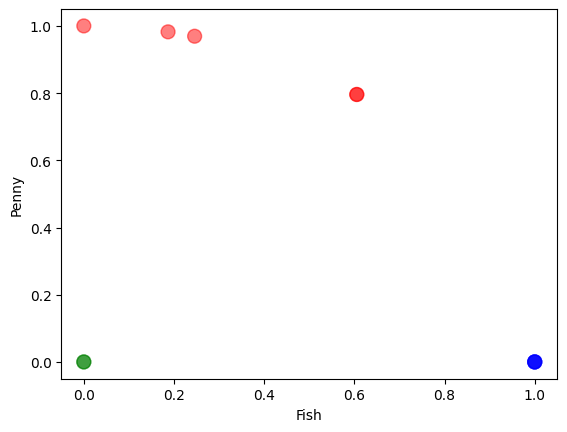

In [23]:
# ilustracija klastera
# boje klastera
color_list = ['r', 'b','g']
colors = [color_list[i] for i in df['category']]

ax = df.plot(kind='scatter', x='fish', y='penny', alpha=0.5, s=100,c=colors)
ax.set_xlabel("Fish")
ax.set_ylabel("Penny")

 * **Klasifikacija** = zadatak utvrđivanja grupe kojom pripada dani podatak.
 * Postupak može biti *nenadziran* ili *nadziran*: **non-supervised/supervised**

# Primjer: Klasifikacija teksta

Klasteriranjem podataka dobili smo **tematske kategorije** dokumenata unutar korpusa. 
> **Pitanje**: kako odrediti kojoj kategoriji pripada novopridošli (nekategorizirani) dokument? 

> **Odgovor**: Primijeniti K-Nearest Neighbour klasifikator ([docs](https://scikit-learn.org/stable/modules/neighbors.html))!


In [24]:
from data import texts2 as texts

# Bag-of-Words
vectorizer = TfidfVectorizer(use_idf=True, stop_words='english')
X = vectorizer.fit_transform(texts)

# klasifikator
text = 'Penny likes to fish a fish.'

from sklearn.cluster import KMeans
# broj klastera
number_of_clusters = 4
km = KMeans(n_clusters=number_of_clusters)
km.fit(X)

# ispisi rezultat
results = pd.DataFrame()
results['text'] = texts
results['category'] = km.labels_
results

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X,km.labels_)
# test uzorak
test=vectorizer.transform([text])
#pprint(test.toarray())

# predikcija
category = classifier.predict(test)
print('Dokument je pridruzen klasteru: ', category)

Dokument je pridruzen klasteru:  [2]
